In [192]:
import pandas as pd
from difflib import SequenceMatcher, get_close_matches
import json, glob, re, time, ast # Para evaluar la string como diccionarios
from urllib import parse , request
from datetime import datetime
import numpy as np
from IPython.display import HTML, display, Image
import tabulate
import re

A mejorar: tomar en cuenta entrada 502 (badgate way)

Comentarios sobre 

<li>Hay calles que aparecen como "calle 4" y otras donde solo aparece 4</li>

In [2]:
path = './data/Nomenclator_calles.csv'
path_prueba_IDE = './data/direcciones_codificadas.csv'
path_prueba_SIAAS = './data/montevideo.csv'
path_base_INE_corregida = './data/Direcciones_INE_codigo_corregido.csv'
errores_INE = './erroresINE/'
#base_INE = './data/direcciones_INE.csv'
#localidades_INE = './data/localidades_INE.csv'
codificador = pd.read_csv(path)

####  Requisitos y directrices sobre los componentes

<li>Padrón: Se compone de tres elementos separados entre ellos por
una barra (/). El primer elemento contiene un número de 7 dígitos
el cual indica el número del padrón. El segundo componente,
cuando existe, refiere a el Bloque el cual se indica mediante letras
mayúsculas (tres caracteres). Por último se señala la unidad
representada por dos letras (SS, EP, si es subsuelo o entrepiso,
respectivamente) y luego números naturales de cuatro dígitos</li>
<li>El nombre de la vialidad se debe
escribir en letras mayúsculas, sin siglas ni abreviaciones (a menos
que se establezca lo contrario en el documento oficial que asigna
el nombre), existiendo entre cada palabra como separador un
espacio en blanco. Cuando el nombre de la vialidad tenga un
número, éste se representa con números arábigos, por ejemplo 18
DE JULIO, CABILDO DE 1815</li>

<li>Letra de puerta: Se debe indicar mediante letras mayúsculas</li>
<li>Nombre del Inmueble: El nombre del inmueble se debe escribir
mediante caracteres alfanuméricos en mayúscula.</li>
<li>Bloque: Deben emplearse las disposiciones catastrales para
identificar el Bloque. Se debe indicar mediante número o letra y
en caso de ser este último se debe emplear letras mayúsculas.</li>
<li>Unidad: Deben emplearse las disposiciones catastrales para
identificar la Unidad.</li>
<li>Torre: Se debe especificar el nombre o número que identifica la
Torre mediante caracteres alfanuméricos en mayúscula.</li>
<li>Barrio: El nombre del barrio se debe escribir con letras
mayúsculas sin siglas ni abreviaciones.</li>
<li>Criterio de geocodificación: Debe primar como criterio
emplear el Tipo 0: Punto de Acceso</li>

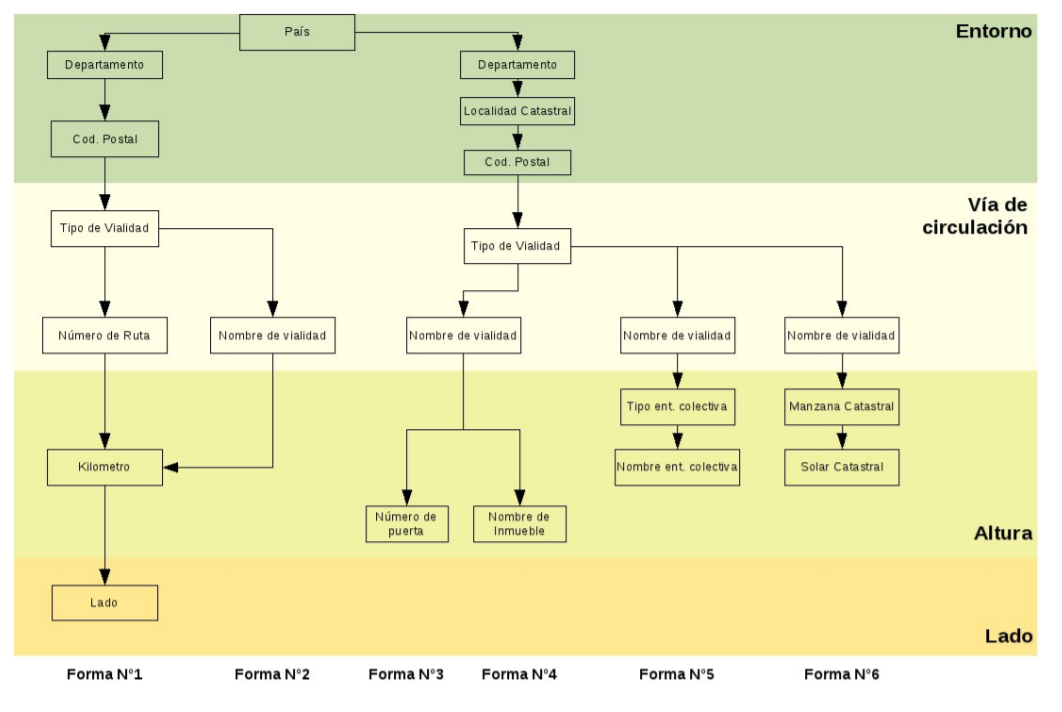

In [3]:
Image("formas_canonicas.png")

<center><h4>Formas canonicas de direcciones</h4></center>

Para el nomeclator. evitar ingresar calle "sin nombre".  Los nombres de las calles que contienen un numero debe de ser en digito

Notas. El principal problema que estoy encontrando es que las calles dentro mismo del nomenclator de INE se encuentran duplicadadas. Un 19% del dataset son entradas con idcalle duplicado. Puede ser que sean la misma calle que continua en otra localidad, ej: avenidad de las instrucciones que comunica toledo chico y montevideo. 
Un 6.5 % de las calles son duplicadas 721 nombres que generan 1888, es decir, se encuentran en la misma localidad y departamento y tienen el mismo nombre. Algunas son calles reales, ej: Progreso tiene 2 calles "Los Olivos" en distintas puntas del pueblo. Montevideo tiene 2 calles "Treinta y tres" (9231, 18853). Otras parecen ser errores de ingresado, ej: 'MACIEL, FRANCISCO ANTOÑO' en tacuarembo aparece con dos id distintos pero es la misma calle. La calle CLITERMNESTRA tiene 3 id distintas en 3 localidades diferentes (2 por cada localidad) lo que generan 6 anotaciones. 

Tambien encontre calles que faltan tanto en el nomenclator de INE como en la API, por ejemplo, 'CARLOS TIZZE' en AIGUA. 

Los calles con nombre de fecha tienen criterios distintos, ejemplo dieciocho de julio, ocho de octubre,veintiuno de setiembre, veinticeis de marzo Vs. 12 DE FEBRERO, 17 DE FEBRERO, ETC. OPCION: ADECUAR EL CODIFICADOR A UN FORMATO UNICO DE FECHAS, QUIZAS LLEVARLAS A NOMBRE?

HAY CALLES EN EL NOMENCLATOR Y API CON NUMERO ESCRITO TEXTUAL 'UNO', 'TRES' Y CON DIGITO '2', '4'

Como se definen dos secuencias iguales. Hablar de SequenceMatcher. El cutoff es de 0.6

In [4]:
def alfanumerical_to_digit(street):
    "Checks if a number is in alfanumerical representation and changes to digits"

    str_to_number = {'PRIMERO':1,
                      'SEGUNDO':2,
                      'TRES':3,
                      'CUATRO':4,
                      'CINCO':5,
                      'SEIS':6,
                      'SIETE':7,
                      'OCHO':8,
                      'NUEVE':9,
                      'DIEZ':10,
                      'ONCE':11,
                      'DOCE':12,
                      'TRECE':13,
                      'CATORCE':14,
                      'QUINCE':15,
                      'DIECISEIS':16,
                      'DIECISIETE':17,
                      'DIECIOCHO':18,
                      'DIECINUEVE':19,
                      'VEINTE':20,
                      'VEINTIUNO':21,
                      'VEINTIDOS':22,
                      'VEINTITRES':23,
                      'VEINTICUATRO':24,
                      'VEINTICINCO':25,
                      'VEINTISEIS':26,
                      'VEINTISIETE':27,
                      'VEINTIOCHO':28,
                      'VEINTINUEVE':29,
                      'TREINTA':30,
                      'TREINTA Y UNO':31
                     }
    
    
    number = list(set(str_to_number.keys())&set(street.split()))
    
    if number:
        number = number[0]
        return street.replace(number,str(str_to_number.get(number)))
    else:
        return street

In [5]:
def digit_to_alfanumerical(street):
    "Checks if a number is in digits representation and changes to alfanumerical"
    
    number_to_string =  {'1': 'UNO',
                         '2': 'DOS',
                         '3': 'TRES',
                         '4': 'CUATRO',
                         '5': 'CINCO',
                         '6': 'SEIS',
                         '7': 'SIETE',
                         '8': 'OCHO',
                         '9': 'NUEVE',
                         '10': 'DIEZ',
                         '11': 'ONCE',
                         '12': 'DOCE',
                         '13': 'TRECE',
                         '14': 'CATORCE',
                         '15': 'QUINCE',
                         '16': 'DIECISEIS',
                         '17': 'DIECISIETE',
                         '18': 'DIECIOCHO',
                         '19': 'DIECINUEVE',
                         '20': 'VEINTE',
                         '21': 'VEINTIUNO',
                         '22': 'VEINTIDOS',
                         '23': 'VEINTITRES',
                         '24': 'VEINTICUATRO',
                         '25': 'VEINTICINCO',
                         '26': 'VEINTISEIS',
                         '27': 'VEINTISIETE',
                         '28': 'VEINTIOCHO',
                         '29': 'VEINTINUEVE',
                         '30': 'TREINTA',
                         '31': 'TREINTA Y UNO'}
    
    number = list(set(number_to_string.keys())&set(street.split()))
    if number:
        number = number[0]
        return street.replace(number,str(number_to_string.get(number)))
    else:
        return street

In [6]:
def suggest_dep(string):
    """Suggest a departamento """
    departamentos =(["artigas",
                    "canelones",
                    "cerro largo",
                    "colonia",
                    "durazno",
                    "flores",
                    "florida",
                    "lavalleja",
                    "maldonado",
                    "montevideo",
                    "paysandú",
                    "río negro",
                    "rivera",
                    "rocha",
                    "salto",
                    "san josé",
                    "soriano",
                    "tacuarembó",
                    "treinta y tres"])
    return get_close_matches(string.lower(),departamentos,n=2,cutoff=0.6)[0]


In [76]:
def process_street(street):
    forbidden_char = ["Nº", "S/N",",","."] #Remplaza caracteres que estorban en la busqueda
    non_street = [999] #Codigos para marcar que no es una calle
    streets_with_digit = ["SENDA","CALLE"]  
    
    # Arregla las calles "SIN NOMBRE". SI S/N Vuelve a aparecer mas adelante es "SIN NUMERO"
    
        
    if street in non_street: 
        return "",""
    
    try:
        street = street.upper() # Se fija si la calle contiene texto, Si es la calle es un numero lo devuelve como string
    except: 
        return str(street) , "" #LA API de IDE acepta las calles con numero en formato str(numero)   str(numero) 
        
    for char in forbidden_char:
        street = street.replace(char,"")
    
    if set(streets_with_digit)&set(street.split()):
        if len(street.split()) > 2:
            street = digit_to_alfanumerical(street[-1])
        else:
            street = digit_to_alfanumerical(street)
    try:
        if not street.split()[-2] in special_streets: #Para ver si el antepenultima palabra no es numero, para que no parsee ej "Senda 8"
            number = int(street.split()[-1])
            street = ' '.join(street.split()[:-1])
        else:
            number = ""
    except Exception as e:
        number = ""
    return street, number

In [81]:
def sugerir_calles(string,tryouts=3):
    """Sugiere calles a partir de una string"""
    query_args = {
        "entrada" : string, # La sugerencia a buscar
        "todos":False
    }
    root = 'https://direcciones.ide.uy/'
    URL = root + '/api/v0/geocode/SugerenciaCalleCompleta?'
    #r = request.Request(
    #        url=URL,
    #        data=parse.urlencode(query_args).encode('utf-8'),
    #    )
    
    while tryouts>0:
        try:
            r = request.urlopen(URL+parse.urlencode(query_args))
            data = r.read().decode('utf-8').replace('null','None')
            break
        except Exception as e:
            tryouts -= 1
            if tryouts == 0:
                print(e)
                return []
            time.sleep(0.5)
            
            
    if data=='[]':
        
        #print('No existe calle similar')
        return []
    else:
        return ast.literal_eval(data)

In [82]:
def sugerir_localidad(localidad,departamento,limit=10,tryouts=3):
    """Sugiere una localidad a partir de una string y checkea contra un departamento devolviendo sugerencia e id"""

    
    departamentos =(["artigas",
                    "canelones",
                    "cerro largo",
                    "colonia",
                    "durazno",
                    "flores",
                    "florida",
                    "lavalleja",
                    "maldonado",
                    "montevideo",
                    "paysandú",
                    "río negro",
                    "rivera",
                    "rocha",
                    "salto",
                    "san josé",
                    "soriano",
                    "tacuarembó",
                    "treinta y tres"])
    
    candidato_departamento = get_close_matches(departamento.lower(),departamentos,n=limit,cutoff=0.6)[0] 
    
    string = localidad + ", "+candidato_departamento
    query_args = {
        "limit": 10,
        "q" : string, # La sugerencia a buscar
        "soloLocalidad":True
    }
    
    
    root = 'https://direcciones.ide.uy/'
    URL = root + 'api/v1/geocode/candidates?'
    while tryouts>0:
        #r = request.Request(
        #        url=URL,
        #        data=parse.urlencode(query_args).encode('utf-8'),
        #    )
        try:
            r = request.urlopen(URL+parse.urlencode(query_args))
            break
        except Exception as e:
            tryouts -= 1
            if tryouts ==0:
                return {'error':e}
            time.sleep(0.5)
    
    data = r.read().decode('utf-8')
    
    if data=='[]':
        return {'error':'No existe localidad similar'}
    else:
        data = ast.literal_eval(data.replace('null','None')) 
    try:
        localidades = [x.get('address').lower().split(',')[0] for x in data]
        idlocalidades = [x.get('idLocalidad') for x in data]
        loc_suggested = get_close_matches(localidad.lower(),localidades,n=limit,cutoff=0.6)[0] #Para localidad el matcheo queda en 0.6
        idloc_suggested = idlocalidades[localidades.index(loc_suggested)]
        return [loc_suggested , idloc_suggested]
    except Exception as e:
        #print("Este erro",e)
        loc_suggested = " "
        idloc_suggested = " "
        return [loc_suggested , idloc_suggested]

In [83]:
def search_from_API(street,loc,dep,warning=False):  #Mejorar la funcion si no tiene localidad
    """Encuentra una localidad dada una calle sugerida y una localidad. Devuelve un diccionario con los datos de esa calle"""
    street, number = process_street(street)
    if street.isdigit():
        street += " " + street # La API busca los numeros de esta forma, ej: "60 60" es una busqueda valida para la calle 60
    suggestions = sugerir_calles(street)  #Consulta por calles similares a la API IDE
    try:
        street = str(street) #Transformo las calles de numeros en strings #transformo las 
    except Exception as e:
        return {'error':'La calle no contiene string'}
    street = street.strip()   #Quito los espacios en blanco
    dep = dep.strip()
    if not suggestions: #Si no se devuelven calles similares
        return  {'error':'No se encuentra calle simular'}
    streets = [x.get('calle').lower() for x in suggestions] # Hay que trabajar con lower dado que las mayusculas afectan el ratio
    suggested_loc = [x.get('localidad').lower() for x in suggestions if x.get('localidad') is not None]
    suggested_idstreet = [x.get('idCalle') for x in suggestions] 
    suggested_idloc = [x.get('idLocalidad') for x in suggestions if x.get('idLocalidad') is not None] 
    suggested_dep = [x.get('departamento').lower() for x in suggestions if x.get('departamento') is not None] 
    suggested_streets = get_close_matches(street.lower(),street,n=14,cutoff=0.6) 
    try:
        loc, idloc = sugerir_localidad(loc.lower(),dep)
    except:
        return {'error':'error al sugerir localidad'}
    if not loc:
        return {'error':"no se encuentra localidad"}

    
    suggested_street_indexes = [x for x in range(len(suggested_loc)) if suggested_loc[x] == loc]
    suggested_streets = [streets[x] for x in suggested_street_indexes]
    suggested_idstreet = [suggested_idstreet[x] for x in suggested_street_indexes]
    suggested_dep =  [suggested_dep[x] for x in suggested_street_indexes]
    suggested_idloc = [suggested_idloc[x] for x in suggested_street_indexes]
   
    if not suggested_streets:
        return {'error':'No se encuentra calle similar'}
    else:
        try:
            result = ({'calle':suggested_streets[0], #Solo se informa el primero
                       'numero': number,
                   'id':suggested_idstreet[0],
                   'localidad':loc,
                   'idlocalidad':idloc,
                   'departamento':suggested_dep[0],
                   'fuente':'API INE'})
            return result
        except Exception as e:
            return {'error':e}


In [84]:
start = datetime.now()
calle = 'Xalto' #8908
localidad = 'Montevideo'
departamento = 'MONTEVIDEO'
print("Sugerir calle dado la entrada {} en la localidad {}".format(calle,localidad))
print(search_from_API(calle,localidad,departamento))
print("El script demoro:", datetime.now() - start)

Sugerir calle dado la entrada Xalto en la localidad Montevideo
{'calle': 'salto', 'numero': '', 'id': 8908, 'localidad': 'montevideo', 'idlocalidad': 3180, 'departamento': 'montevideo', 'fuente': 'API INE'}
El script demoro: 0:00:00.213307


In [184]:
def search_from_frame(street,loc,dep,df):
    "Hace una busqueda en en cascada dep/loc/calle devolviendo un diccionario de datos"
    dep = dep.upper() #Pasa a mayusculas ya que esta asi en el DF 
    loc = loc.upper()
    street, number = process_street(street)
    try:
        suggested_dep = get_close_matches(dep,df.departamento.unique(),n=14,cutoff=0.6)[0] #Prueba buscar el departamento
    except: 
        return {'error':'No se encuentra departamento en el frame'}
    try:
        suggested_loc = get_close_matches(loc,df[df['departamento']==suggested_dep]['localidad'].unique(),n=14,cutoff=0.8)[0]
        
    except Exception as e:
        return {'error':'No encuentro localidad en el nomenclator'} 
    try:
        suggested_street = get_close_matches(street,df[(df['departamento']==suggested_dep)&(df['localidad']==suggested_loc)]['calle'].unique(),n=10,cutoff=0.6)[0]
    except Exception as e:
        try: #Si la distancia de edición no funciona cuento cuantas veces aparecen los nombres de las palabras dentro de la calle en los candidatos. Quien tiene más palabras gana
            candidates = df[(df['departamento']==suggested_dep)&(df['localidad']==suggested_loc)]['calle'].unique()
            word_counts = [count_matches(street,candidate) for candidate in candidates]
            if sum(word_counts) == 0:
                return {'error': 'No se encuentran los datos ingresados'}
            suggested_street = candidates[np.argmax(word_counts)]
        except:
            return {'error': 'No se encuentran los datos ingresados'}
        
    try:
        _ , idloc = sugerir_localidad(suggested_loc,suggested_dep,limit=10)
        if len(df[(df['departamento']==suggested_dep)&(df['calle']==suggested_street)&(df['localidad']==suggested_loc)]['idcalle']) > 1:
            return {'error':'Calle duplicada'}
        
        result = ({'calle':suggested_street , #Solo se informa el primero
                   'numero': number,
                   'id': int(df[(df['departamento']==suggested_dep)&(df['calle']==suggested_street)&(df['localidad']==suggested_loc)]['idcalle']),
                   'localidad':suggested_loc,
                   'idlocalidad':idloc,
                   'departamento':suggested_dep,
                   'fuente':'Codificador'})
        return result
    except:
        return {'error': 'No se encuentran los datos ingresados'}


In [103]:
def count_matches(string1,string2):
    "Cuenta cuantas veces aparecen las palabras de una calle en otra"
    return sum([string2.count(x) for x in string1.split()])

In [147]:
def get_data_IDE(street,loc,dep,df):
    
    # HAY QUE ARREGLAR EL ULTIMO RETURN, esta en MODO DEBUG 
    
    error = ""
    # ----------
    
    sprecial_words = ["CALLE"]
    special_charecters = [",","-"]
    possible_locs = []
    
    
    
    for char in special_charecters: #Search for only one of this characters. 
        if char in loc:
            possible_locs = loc.split(char)
            break
    
    if isinstance(loc,str) :
        possible_locs.append(loc)
    else:
        possible_locs = [x.strip().upper() for x in possible_locs]
        
    if not dep:
        for loc in possible_locs:
            dep = suggest_dep(loc)
            if dep:
                possible_locs.pop(possible_locs.index(loc))
                break
    
    #### Caso especial, calles con fecha ambigua ---------------------------------
    try:
        number = int(street.split()[0])
        for loc in possible_locs:
            result = search_from_frame(street,loc,dep,df)
            if 'error' not in result.keys():
                return result
            else:
                error = result.get('error')
    except:
        None
        
    street = alfanumerical_to_digit(street) ### Reemplaza numeros de fechas letra a alfanumerico. 
    # Esto va fuera de process_street debido a que algunas fechas en la base tienen numero en digito y otros en alfanumerico
    
    
    ### --------------------------------------------------------------------------
    
    for loc in possible_locs:
        result = search_from_API(street,loc,dep)
        if not 'error' in result.keys():
            return result
        else:
            if not error:
                error = ' '.join((error,result.get('error')))
            else:
                error = result.get('error')
            result = search_from_frame(street,loc,dep,df)
            
            if 'error' in result.keys():
                error = ' '.join((error,result.get('error')))
                return {'error':error}
            
    return result

  ##### Esto hay que arreglarlo al final, cuando se termine el debug y agregar el error 404
    
    
            #if not 'error' result:
            #    return result  
    
            # Continua al proximo juego de palabras de la lista
    #return {} # Si no encuentra match devuelve vacio (HAY QUE DEVOLVER ERROR 404)

In [216]:
def search_street(street,loc,dep,df):
    result = get_data_IDE(street,loc,dep,df)
    special_streets = [("S/N","SIN NOMBRE"),("SN","SIN NOMBRE"),("CALLE","")] #Las calles especiales y sus correspondientes normalizaciones
    if 'error' in result.keys():
        for special in special_streets:
            if special[0] in street.upper():
                street = street.upper().replace(special[0],special[1])
                result = get_data_IDE(street,loc,dep,df)
                if 'error' not in result.keys():
                    break
    return result
    ### Reemplaza numeros de fechas letra a alfanumerico. 
    # Esto va fuera de process_street debido a que algunas fechas en la base tienen numero en digito y otros en alfanumerico
    

In [217]:
calle = "TATA"
localidad = "montevideo ,montevideo"
departamento = ""
search_street(calle, localidad, departamento,codificador)

{'calle': 'taita',
 'numero': '',
 'id': 11246,
 'localidad': 'montevideo',
 'idlocalidad': 3180,
 'departamento': 'montevideo',
 'fuente': 'API INE'}

In [106]:
#df_prueba1 = pd.read_csv(path_prueba1,sep=";",encoding = "ISO-8859-1")
#print("Antes de limpiar el dataframe tiene {} filas y {} columas".format(df_prueba1.shape[0],df_prueba1.shape[1]))
#df_prueba1 = df_prueba1[~df_prueba1['departamento'].isnull()] 
#df_prueba1.reset_index(inplace=True)
#df_prueba1.drop(columns=['index'],inplace=True)
#print("Dsp de limpiar el dataframe tiene {} filas y {} columas".format(df_prueba1.shape[0],df_prueba1.shape[1]))
#df_prueba1.head()

In [107]:
def check_results_from_dataframe(columna_calle,columna_localidad,columna_departamento,frame,referencia):
    "Analiza un frame para buscar calles"
    dep_error = []
    loc_error = []
    calle_error = []
    error = []
    start = datetime.now()
    counter = 0
    df_append = pd.DataFrame()
    for index, row in frame.iterrows():
        counter += 1
        if counter%1000 == 0:
            #d = {'calle':calle_error, 'localidad':loc_error,'departamento':dep_error}
            #inter = pd.DataFrame(data = d)
            #df_append.append(inter)
            print("Van {} y faltan {}, van {} errores".format(counter,frame.shape[0] - counter,len(dep_error)))
            print("Van {} minutos".format((datetime.now() - start).seconds/60))
        calle = row[columna_calle]
        localidad =  row[columna_localidad].strip()
        if isinstance(row[columna_departamento], str):
            departamento = row[columna_departamento].strip()
        else:
            departamento = ""
        result = search_street(calle,localidad,departamento,referencia)
        if 'error' in result.keys():
            dep_error.append(departamento)
            loc_error.append(localidad)
            calle_error.append(calle)
            error.append(result.get('error'))
    d = {'calle':calle_error, 'localidad':loc_error,'departamento':dep_error,'error':error}
    inter = pd.DataFrame(data = d)
    df_append = df_append.append(inter)
    return df_append

In [108]:
def check_IDE_dataset(df_prueba1,df):
    dep_error = []
    loc_error = []
    calle_error = []
    id_error = []
    tipo_error = []

    for index, row in df_prueba1.iterrows():
        if index%1000 == 0:
            print("Van {} y faltan {}, van {} errores".format(index,df_prueba1.shape[0]-index,len(dep_error)))

        calle = str(row['calle'])
        localidad =  row['localidad'].strip()
        departamento = row['departamento'].strip()

        try:
            id_calle = int(row['idCalle'])
        except:
            id_calle = np.nan

      #Da 500 ms de espera para que la API no me bloquee
       #  try: # Prueba si la calle es valida
       #    if int(row[columna_calle]):
       #         dep_error.append(row[columna_departamento].strip())
       #         loc_error.append(row[columna_localidad].strip())
       #         calle_error.append(row[columna_calle])
       #         #id_error.append(row['idCalle']) #Solo para df de INE
       #          tipo_error.append("La calle no es valida")
       # except:
       #     None

        result = search_street(calle,localidad,departamento,df)
        #print(index,result)
        if not result:
            dep_error.append(departamento.strip())
            loc_error.append(localidad.strip())
            calle_error.append(calle)
            id_error.append(id_calle) 
            tipo_error.append("Resultado vacio")
            #print("aca",result,row['calle'])
            continue
        try:     
            if  result.get('id') != id_calle and not np.isnan(id_calle):
                dep_error.append(departamento.strip())
                loc_error.append(localidad.strip())
                calle_error.append(calle)
                id_error.append(id_calle)
                tipo_error.append("Difieren ids")
                continue

                #print(row['departamento'].strip(),row['localidad'.strip()],row['calle'].strip())
        except Exception as e:
            dep_error.append(departamento.strip())
            loc_error.append(localidad.strip())
            calle_error.append(calle)
            id_error.append(id_calle)
            tipo_error.append(e)
            print("Hubo un error",e,departamento,localidad,id_calle)

    # Genera el dataframe con los errores
    d = {'calle':calle_error,'id':id_error, 'localidad':loc_error,'departamento':dep_error,'tipo error':tipo_error}
    error_API_DF = pd.DataFrame(data = d) 
    error_API_DF.to_csv('errores buscando por API y DF.csv',index=False)
    print("Archivo generado con éxito, se detactaron {} errores".format(len(calle_error)))
    print("El script demoró {} minutos".format((datetime.now()-start).minutes)/60)
    return error_API_DF

In [109]:
#df_prueba1 = pd.read_csv(path_prueba_IDE, sep=";", header=0,encoding = "ISO-8859-1") 
#df_prueba1.dropna(subset=['calle'],inplace=True)
#df_errores_IDE = check_results_from_dataframe('calle','localidad','departamento',df_prueba1,codificador)

In [110]:
#"Son {0:.2f} % de errores".format(df_errores_IDE.shape[0]/df_prueba1.shape[0]*100)

In [111]:
#df_errores_IDE.sample(20)

In [112]:
# Para checkear el dataset de SIIAS

#df_prueba2 = pd.read_csv(path_prueba2,encoding = "ISO-8859-1", error_bad_lines=False)
##a_borrar = 14000
#df_prueba2.drop(range(a_borrar),inplace=True)
#A = df_prueba2.loc[270000:272000]

In [113]:
#Lista de errores encontrados en sias /
def print_siias_error():
    table = [["calle","localidad","departamento"],
    ['','','MONTEVIDEO'],
    ['DOS','MONTEVIDEO','MONTEVIDEO'],
    ['TREINTA Y TRES','MONTEVIDEO','MONTEVIDEO'],
    ['SBRE DE PASO','MELILLA','MONTEVIDEO'],
    ['CAMINO AL PASO HONDO',"","MONTEVIDEO"]]

    display(HTML(tabulate.tabulate(table, tablefmt='html')))

In [114]:
months = (["ENERO",
               "FEBRERO",
               "MARZO",
               "ABRIL",
               "MAYO",
               "JUNIO",
               "JULIO",
               "AGOSTO",
               "SETIEMBRE", #SEPTIEMBRE TMB?
               "OCTUBRE",
               "NOVIEMBRE",
               "DICIEMBRE"]) 

In [115]:
path_errores_INE = 'path + "/*.csv"'
all_files = glob.glob(errores_INE + "/*.csv")
li = []
errores = pd.DataFrame()
for filename in all_files:
    print(filename)
    dataframe = pd.read_csv(filename)
    li.append(dataframe)
errores = errores.append(li)
error_rate = errores.shape[0] /(1500000/25 * len(all_files)) * 100
print("Hay {} errores en la base hasta ahora, un {} % de lo analizado".format(str(errores.shape[0]),str(error_rate)))
errores.drop_duplicates(inplace=True)
errores.calle = errores.calle.str.strip()

./erroresINE\Errores en base INE parte_0.csv
./erroresINE\Errores en base INE parte_1.csv
./erroresINE\Errores en base INE parte_10.csv
./erroresINE\Errores en base INE parte_11.csv
./erroresINE\Errores en base INE parte_12.csv
./erroresINE\Errores en base INE parte_13.csv
./erroresINE\Errores en base INE parte_14.csv
./erroresINE\Errores en base INE parte_15.csv
./erroresINE\Errores en base INE parte_16.csv
./erroresINE\Errores en base INE parte_17.csv
./erroresINE\Errores en base INE parte_18.csv
./erroresINE\Errores en base INE parte_19.csv
./erroresINE\Errores en base INE parte_2.csv
./erroresINE\Errores en base INE parte_20.csv
./erroresINE\Errores en base INE parte_21.csv
./erroresINE\Errores en base INE parte_22.csv
./erroresINE\Errores en base INE parte_23.csv
./erroresINE\Errores en base INE parte_24.csv
./erroresINE\Errores en base INE parte_3.csv
./erroresINE\Errores en base INE parte_4.csv
./erroresINE\Errores en base INE parte_5.csv
./erroresINE\Errores en base INE parte_6

In [222]:
errores_recheckeo = check_results_from_dataframe('calle','localidad','departamento',errores,codificador)

Van 1000 y faltan 25108, van 323 errores
Van 4.633333333333334 minutos
Van 2000 y faltan 24108, van 562 errores
Van 9.216666666666667 minutos
Van 3000 y faltan 23108, van 755 errores
Van 14.45 minutos
HTTP Error 502: Proxy Error
Van 4000 y faltan 22108, van 1080 errores
Van 20.05 minutos
Van 5000 y faltan 21108, van 1359 errores
Van 25.0 minutos
Van 6000 y faltan 20108, van 1508 errores
Van 31.183333333333334 minutos
Van 7000 y faltan 19108, van 1732 errores
Van 36.03333333333333 minutos
Van 8000 y faltan 18108, van 1856 errores
Van 40.53333333333333 minutos
Van 9000 y faltan 17108, van 2367 errores
Van 45.266666666666666 minutos
Van 10000 y faltan 16108, van 2779 errores
Van 49.416666666666664 minutos
Van 11000 y faltan 15108, van 3151 errores
Van 54.25 minutos
Van 12000 y faltan 14108, van 3574 errores
Van 58.78333333333333 minutos
Van 13000 y faltan 13108, van 3833 errores
Van 63.28333333333333 minutos
Van 14000 y faltan 12108, van 4298 errores
Van 67.6 minutos
Van 15000 y faltan 11

In [226]:
search_street('RUTA 8 VIEJA',"PANDO",'CANELONES',codificador)

{'error': ' No se encuentra calle simular Calle duplicada'}

In [221]:
LOCALIDAD = "montevideo".upper()
DEPARTAMENTO = "montevideo".upper()
street = "SIN NOMBRE"
codificador[(codificador['localidad']==LOCALIDAD)&(codificador['departamento']==DEPARTAMENTO)&(codificador['calle']==street)]

,idcalle,calle,localidad,departamento
4036,15554,SIN NOMBRE,MONTEVIDEO,MONTEVIDEO


In [232]:
codificador[codificador.calle.str.contains("RUTA 8")].calle.unique()

array(['DEPARTAMENTAL A RUTA 8', '2DA. ENTRADA CASI RUTA 8',
       '9 (SALE A RUTA 8)', 'PROGRESO (SALE A RUTA 84)',
       '2A. ENTRADA A RUTA 8', 'VECINAL DE RUTA 84',
       'RUTA 8 - BRIG. GRAL. JUAN A. LAVALLEJA', 'RUTA 81', 'RUTA 82',
       'RUTA 87'], dtype=object)

In [233]:
errores_recheckeo.to_csv('errores_recheckeo_29_9.csv',index=False)

In [234]:
errores_recheckeo.sample(20)

,calle,localidad,departamento,error
9459,S/N 908,Caserio El Cerro,colonia,No se encuentra calle simular No se encuentra...
2064,,Isidoro Noblía,cerro largo,No se encuentra calle similar No se encuentra...
815,SIN/910,Totoral del Sauce,canelones,No se encuentra calle simular No se encuentra...
4004,ORION,Pinares - Las Delicias,maldonado,No se encuentra calle similar No encuentro lo...
4803,CALLE CERRADA,Sauce de Portezuelo,maldonado,No se encuentra calle similar No se encuentra...
7876,CALLE L,Delta del Tigre y Villas,san josé,No se encuentra calle similar No encuentro lo...
1400,S/N 901,Neptunia,canelones,No se encuentra calle simular No se encuentra...
914,CALLE 2,Estación Migues,canelones,No se encuentra calle simular No se encuentran...
6433,CALLE 900,Puimayen,rocha,No se encuentra calle simular No se encuentran...
1645,TEXAS,Barra de Carrasco,canelones,No se encuentra calle similar No se encuentra...
